Using device: cuda
🔬 CORAL BLEACHING U-NET TRAINING PIPELINE
Found 526 train samples
Found 132 val samples
📊 Dataset sizes:
  Training: 526 images
  Validation: 132 images
  Batch size: 8
Calculating class weights...


100%|██████████| 66/66 [00:13<00:00,  4.93it/s]


Class distribution:
  Background: 87,940,272 pixels (63.8%)
  Healthy coral: 36,097,364 pixels (26.2%)
  Bleached coral: 13,850,111 pixels (10.0%)
Class weights: [0.5226567983627319, 1.2732945680618286, 3.3185713291168213]
🏗️ Model created with 31,037,763 parameters


/tmp/ipykernel_36/2529808305.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🚀 Starting training for 5 epochs...


Epoch 1/5 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s, loss=1.6075]



Epoch 1/5:
  Train Loss: 0.9153
  Val Loss: 1.2820
  Val IoU - Background: 0.6535
  Val IoU - Healthy: 0.0446
  Val IoU - Bleached: 0.3170
  Mean IoU: 0.3384
  💾 New best model saved! (IoU: 0.3384)


Epoch 2/5 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s, loss=0.8902]



Epoch 2/5:
  Train Loss: 0.8434
  Val Loss: 0.8070
  Val IoU - Background: 0.3527
  Val IoU - Healthy: 0.2853
  Val IoU - Bleached: 0.4255
  Mean IoU: 0.3545
  💾 New best model saved! (IoU: 0.3545)


Epoch 3/5 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s, loss=0.9454]



Epoch 3/5:
  Train Loss: 0.8342
  Val Loss: 0.8790
  Val IoU - Background: 0.2578
  Val IoU - Healthy: 0.2561
  Val IoU - Bleached: 0.2962
  Mean IoU: 0.2700


Epoch 4/5 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s, loss=0.9091]



Epoch 4/5:
  Train Loss: 0.8245
  Val Loss: 0.8155
  Val IoU - Background: 0.5540
  Val IoU - Healthy: 0.2328
  Val IoU - Bleached: 0.3696
  Mean IoU: 0.3855
  💾 New best model saved! (IoU: 0.3855)


Epoch 5/5 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s, loss=0.9256]



Epoch 5/5:
  Train Loss: 0.8118
  Val Loss: 0.8565
  Val IoU - Background: 0.4200
  Val IoU - Healthy: 0.2325
  Val IoU - Bleached: 0.3099
  Mean IoU: 0.3208

📊 Visualizing results...
Predictions saved to /kaggle/working/unet_predictions.png


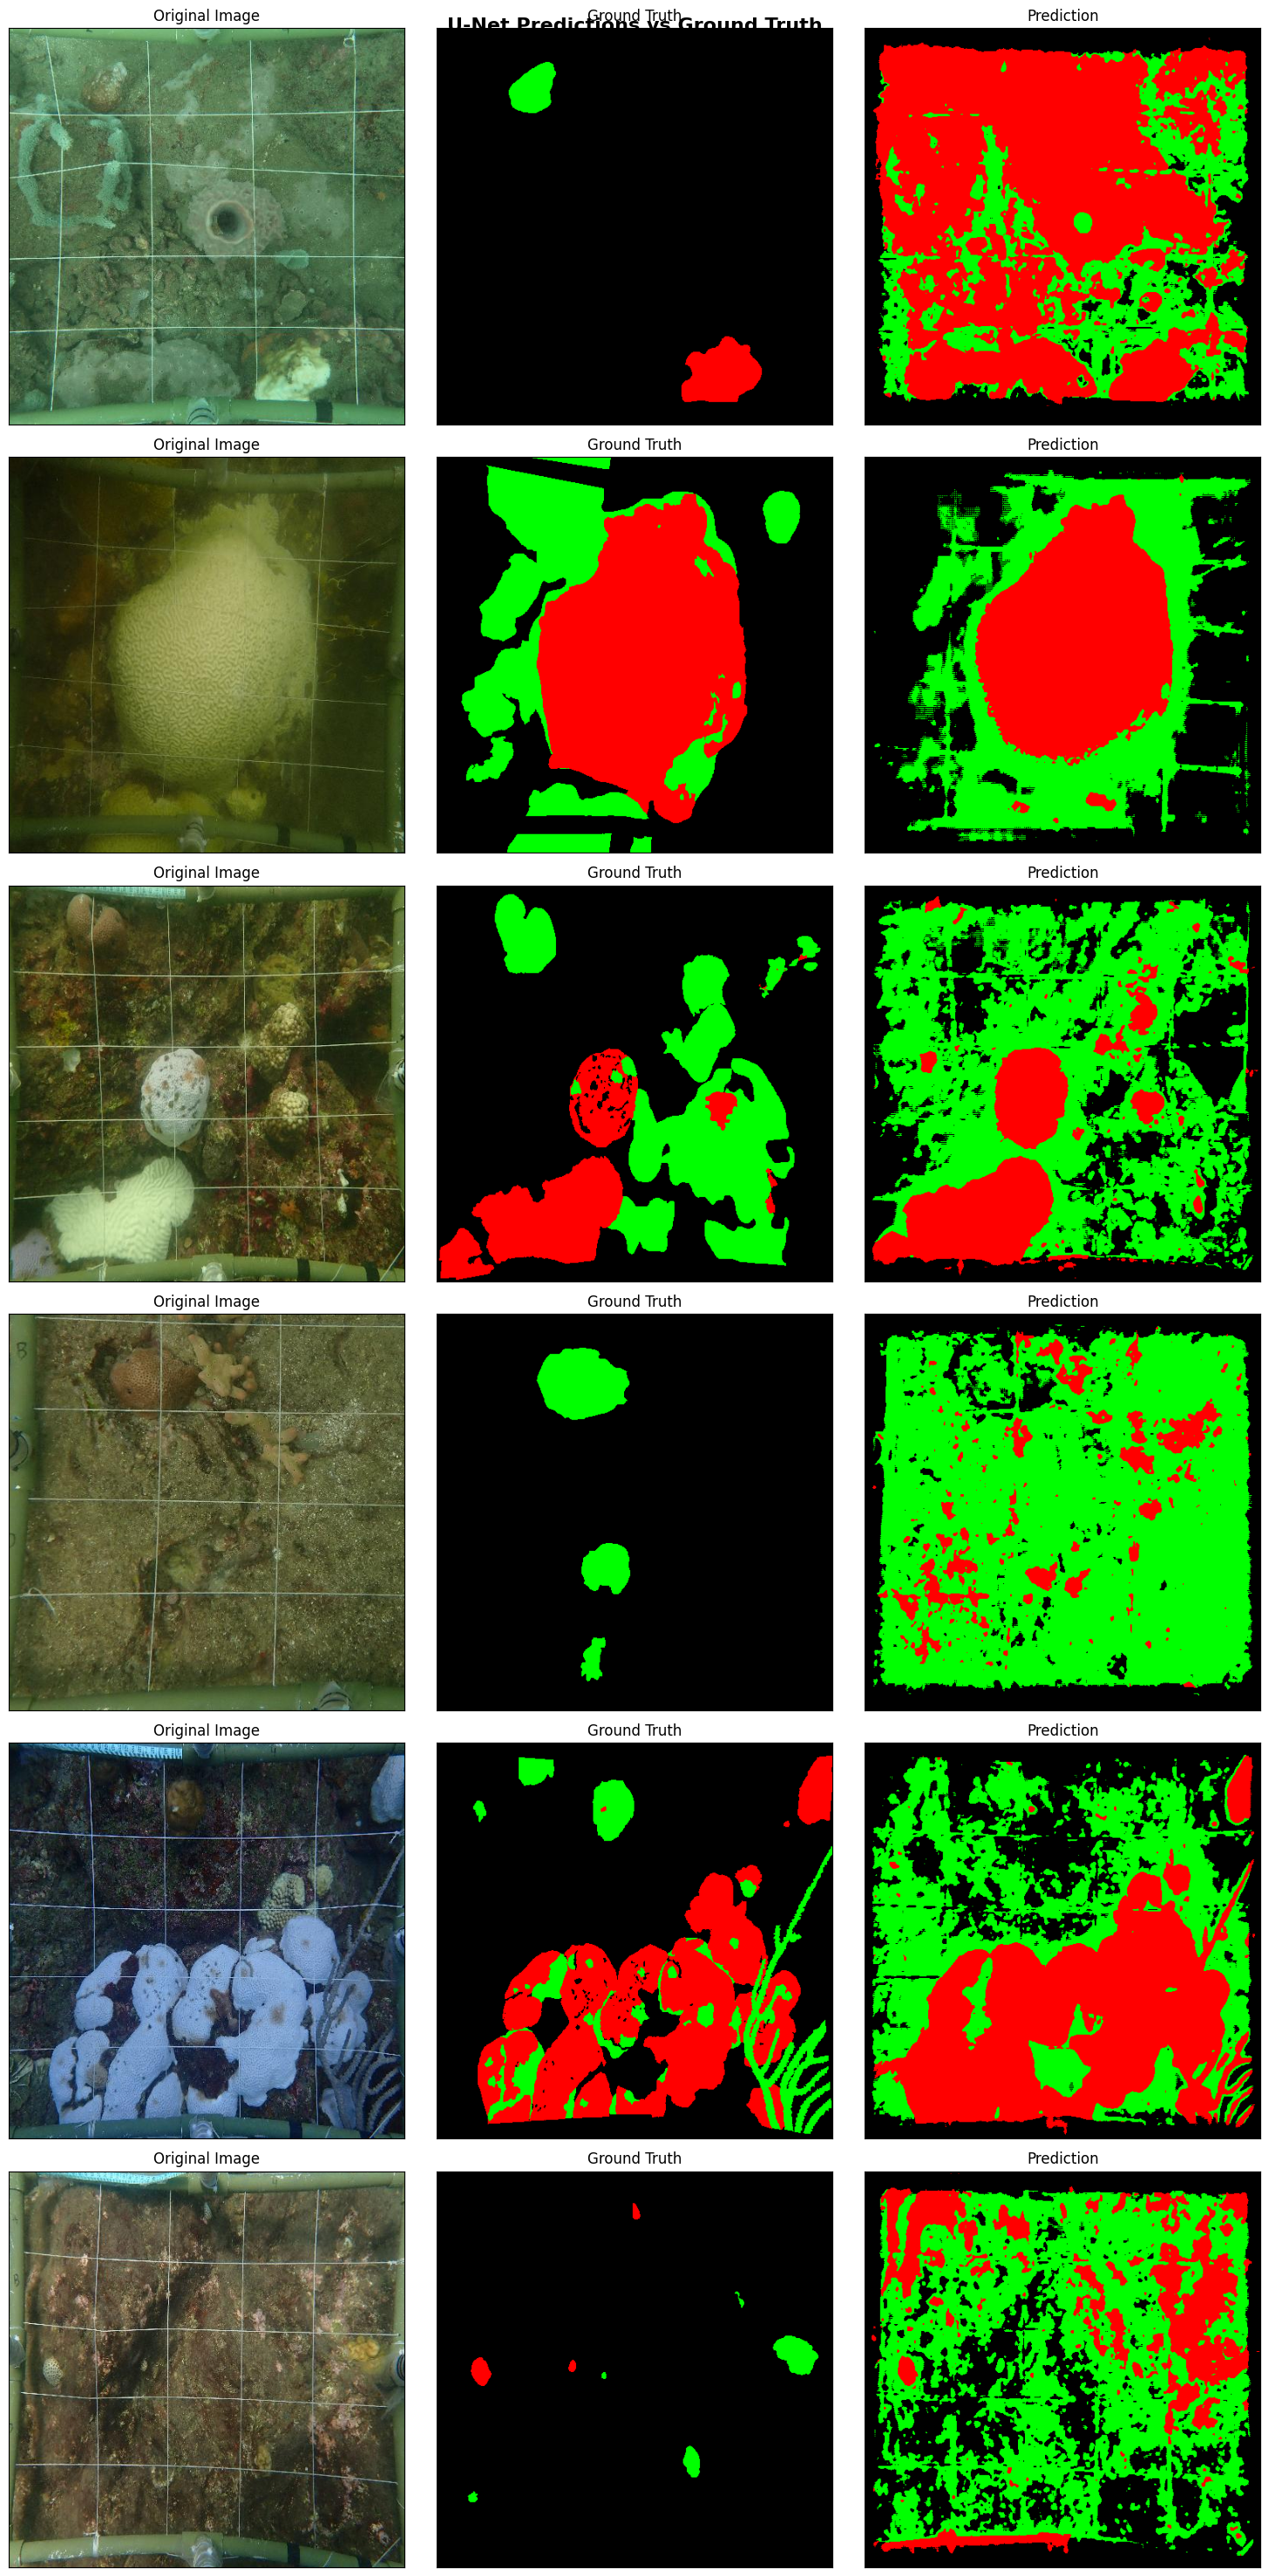

Training history saved to /kaggle/working/training_history.png


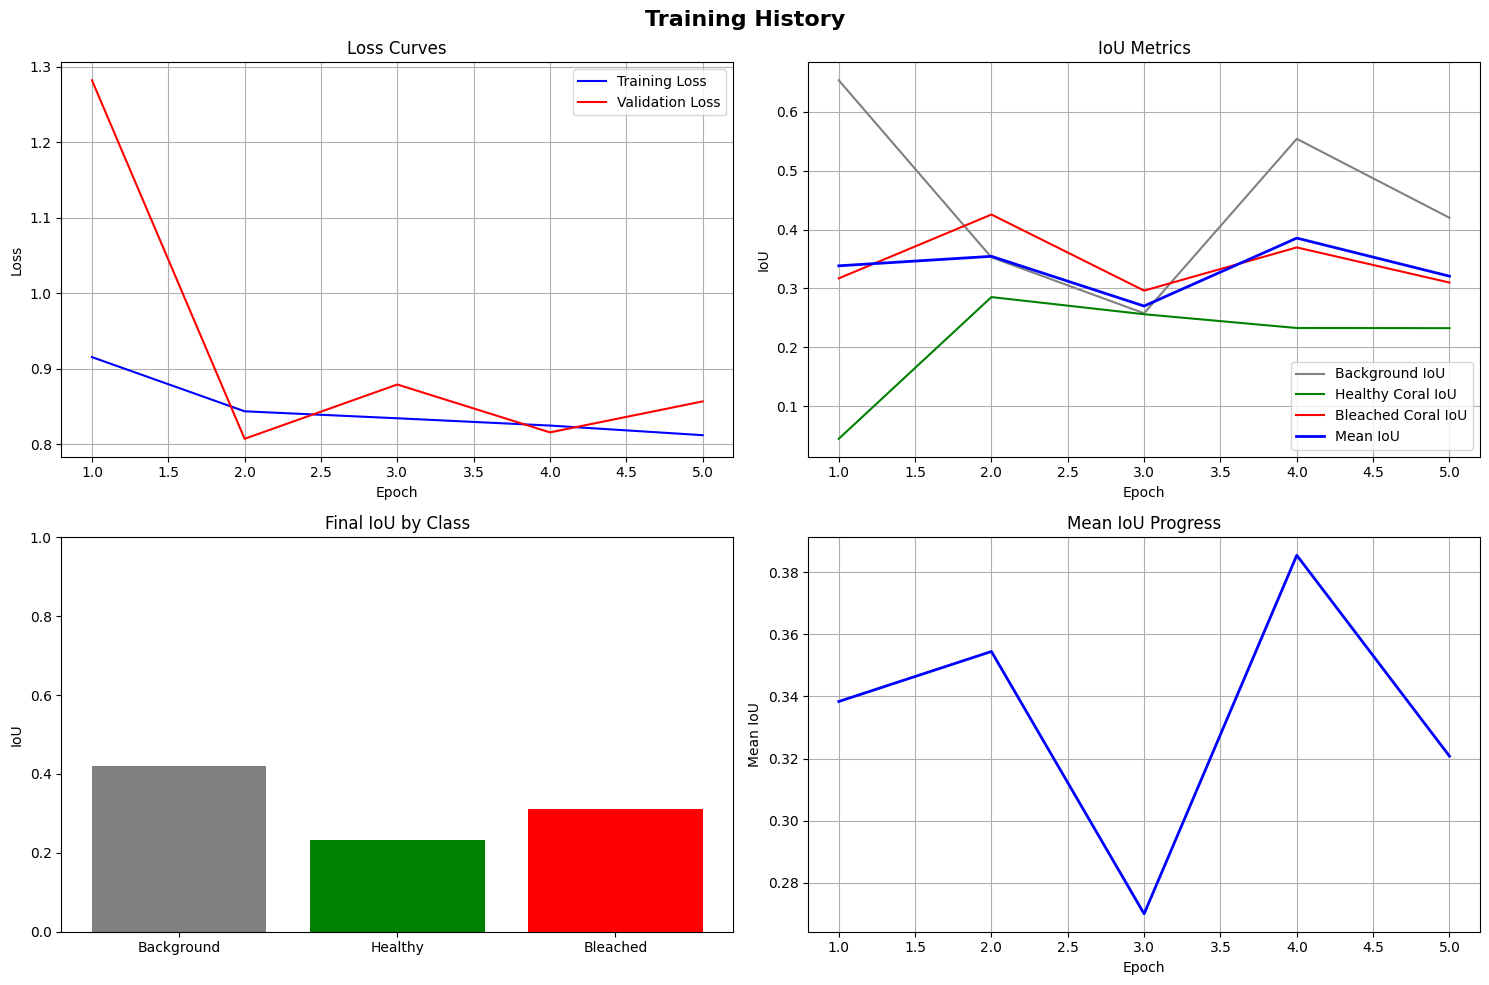

✅ Training complete!


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import json
from tqdm import tqdm
from sklearn.metrics import jaccard_score
import cv2

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class CoralDataset(Dataset):
    """Dataset class for coral bleaching data"""
    
    def __init__(self, data_dir, split='train', transform=None):
        """
        Args:
            data_dir: Path to preprocessed dataset
            split: 'train' or 'val'
            transform: Optional transforms
        """
        self.data_dir = Path(data_dir) / split
        self.transform = transform
        
        # Get all image files
        self.image_files = [f for f in os.listdir(self.data_dir / 'images') 
                           if f.endswith('.npy')]
        
        print(f"Found {len(self.image_files)} {split} samples")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Get filename without extension
        img_file = self.image_files[idx]
        base_name = os.path.splitext(img_file)[0]
        
        # Load image and masks
        image = np.load(self.data_dir / 'images' / img_file)
        bleach_mask = np.load(self.data_dir / 'masks_bleached' / f'{base_name}_bleached.npy')
        healthy_mask = np.load(self.data_dir / 'masks_non_bleached' / f'{base_name}_non_bleached.npy')
        
        # Create 3-class segmentation mask
        # 0 = background, 1 = healthy coral, 2 = bleached coral
        segmentation_mask = np.zeros_like(bleach_mask, dtype=np.int64)
        segmentation_mask[healthy_mask == 1] = 1    # Healthy coral = class 1
        segmentation_mask[bleach_mask == 1] = 2     # Bleached coral = class 2
        
        # Convert to torch tensors
        if len(image.shape) == 3:  # RGB image
            image = torch.from_numpy(image.transpose(2, 0, 1)).float()  # HWC -> CHW
        else:  # Grayscale
            image = torch.from_numpy(image).unsqueeze(0).float()  # Add channel dim
        
        mask = torch.from_numpy(segmentation_mask).long()
        
        # Apply transforms if any
        if self.transform:
            image, mask = self.transform(image, mask)
        
        return image, mask

class DoubleConv(nn.Module):
    """Double convolution block used in U-Net"""
    
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """U-Net architecture for coral bleaching segmentation"""
    
    def __init__(self, n_channels=3, n_classes=3, base_channels=64):
        """
        Args:
            n_channels: Number of input channels (3 for RGB)
            n_classes: Number of output classes (3: background, healthy, bleached)
            base_channels: Base number of channels (64 is standard)
        """
        super(UNet, self).__init__()
        
        # Encoder (contracting path)
        self.inc = DoubleConv(n_channels, base_channels)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base_channels, base_channels*2))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base_channels*2, base_channels*4))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base_channels*4, base_channels*8))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base_channels*8, base_channels*16))
        
        # Decoder (expanding path)
        self.up1 = nn.ConvTranspose2d(base_channels*16, base_channels*8, 2, stride=2)
        self.conv1 = DoubleConv(base_channels*16, base_channels*8)
        
        self.up2 = nn.ConvTranspose2d(base_channels*8, base_channels*4, 2, stride=2)
        self.conv2 = DoubleConv(base_channels*8, base_channels*4)
        
        self.up3 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 2, stride=2)
        self.conv3 = DoubleConv(base_channels*4, base_channels*2)
        
        self.up4 = nn.ConvTranspose2d(base_channels*2, base_channels, 2, stride=2)
        self.conv4 = DoubleConv(base_channels*2, base_channels)
        
        # Final classifier
        self.outc = nn.Conv2d(base_channels, n_classes, 1)
    
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)      # 64 channels
        x2 = self.down1(x1)   # 128 channels
        x3 = self.down2(x2)   # 256 channels
        x4 = self.down3(x3)   # 512 channels
        x5 = self.down4(x4)   # 1024 channels
        
        # Decoder with skip connections
        x = self.up1(x5)                           # Upsample
        x = torch.cat([x4, x], dim=1)              # Skip connection
        x = self.conv1(x)                          # Double conv
        
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)
        
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)
        
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)
        
        # Final prediction
        logits = self.outc(x)
        return logits

class WeightedCrossEntropyLoss(nn.Module):
    """Weighted cross-entropy loss for handling class imbalance"""
    
    def __init__(self, weights=None):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.weights = weights
        if weights is not None:
            self.weights = torch.tensor(weights, dtype=torch.float32)
    
    def forward(self, inputs, targets):
        if self.weights is not None:
            self.weights = self.weights.to(inputs.device)
            return F.cross_entropy(inputs, targets, weight=self.weights)
        else:
            return F.cross_entropy(inputs, targets)

def calculate_class_weights(dataloader):
    """Calculate class weights based on frequency"""
    class_counts = torch.zeros(3)  # 3 classes: background, healthy, bleached
    
    print("Calculating class weights...")
    for images, masks in tqdm(dataloader):
        for class_id in range(3):
            class_counts[class_id] += torch.sum(masks == class_id)
    
    # Calculate weights (inverse frequency)
    total_pixels = class_counts.sum()
    class_weights = total_pixels / (3 * class_counts)
    
    print(f"Class distribution:")
    print(f"  Background: {class_counts[0]:,.0f} pixels ({class_counts[0]/total_pixels:.1%})")
    print(f"  Healthy coral: {class_counts[1]:,.0f} pixels ({class_counts[1]/total_pixels:.1%})")
    print(f"  Bleached coral: {class_counts[2]:,.0f} pixels ({class_counts[2]/total_pixels:.1%})")
    print(f"Class weights: {class_weights.tolist()}")
    
    return class_weights

def calculate_iou(pred_mask, true_mask, num_classes=3):
    """Calculate IoU (Intersection over Union) for each class"""
    ious = []
    
    for class_id in range(num_classes):
        pred_class = (pred_mask == class_id)
        true_class = (true_mask == class_id)
        
        intersection = torch.sum(pred_class & true_class).float()
        union = torch.sum(pred_class | true_class).float()
        
        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0  # Perfect if both are empty
        else:
            iou = intersection / union
        
        ious.append(iou.item())
    
    return ious

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, 
               class_weights=None, save_dir='/kaggle/working'):
    """Train the U-Net model"""
    
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Loss and optimizer
    if class_weights is not None:
        criterion = WeightedCrossEntropyLoss(weights=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_iou_background': [],
        'val_iou_healthy': [],
        'val_iou_bleached': [],
        'val_mean_iou': []
    }
    
    best_val_iou = 0.0
    
    print(f"\n🚀 Starting training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, masks in train_bar:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_ious = [[], [], []]  # For each class
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, masks in val_bar:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Calculate IoU
                pred_masks = torch.argmax(outputs, dim=1)
                batch_ious = calculate_iou(pred_masks, masks)
                
                for i, iou in enumerate(batch_ious):
                    all_ious[i].append(iou)
                
                val_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        val_loss /= len(val_loader)
        
        # Average IoUs
        avg_ious = [np.mean(class_ious) for class_ious in all_ious]
        mean_iou = np.mean(avg_ious)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_iou_background'].append(avg_ious[0])
        history['val_iou_healthy'].append(avg_ious[1])
        history['val_iou_bleached'].append(avg_ious[2])
        history['val_mean_iou'].append(mean_iou)
        
        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Val Loss: {val_loss:.4f}')
        print(f'  Val IoU - Background: {avg_ious[0]:.4f}')
        print(f'  Val IoU - Healthy: {avg_ious[1]:.4f}')
        print(f'  Val IoU - Bleached: {avg_ious[2]:.4f}')
        print(f'  Mean IoU: {mean_iou:.4f}')
        
        # Save best model
        if mean_iou > best_val_iou:
            best_val_iou = mean_iou
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': mean_iou,
                'history': history
            }, save_dir / 'best_unet_model.pth')
            print(f'  💾 New best model saved! (IoU: {mean_iou:.4f})')
    
    return history

def visualize_predictions(model, val_loader, num_samples=6, save_path=None):
    """Visualize model predictions vs ground truth"""
    model.eval()
    
    # Get some validation samples
    data_iter = iter(val_loader)
    images, true_masks = next(data_iter)
    
    # Make predictions
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        pred_masks = torch.argmax(outputs, dim=1).cpu().numpy()
    
    images = images.cpu().numpy()
    true_masks = true_masks.cpu().numpy()
    
    # Create visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('U-Net Predictions vs Ground Truth', fontsize=16, fontweight='bold')
    
    # Color maps for classes
    class_colors = np.array([
        [0, 0, 0],        # Background - black
        [0, 255, 0],      # Healthy coral - green  
        [255, 0, 0]       # Bleached coral - red
    ])
    
    for i in range(min(num_samples, len(images))):
        # Original image
        img = images[i].transpose(1, 2, 0)  # CHW -> HWC
        if img.shape[2] == 1:  # Grayscale
            img = img.squeeze()
            axes[i, 0].imshow(img, cmap='gray')
        else:  # RGB
            axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        
        # Ground truth
        true_colored = class_colors[true_masks[i]]
        axes[i, 1].imshow(true_colored)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])
        
        # Prediction
        pred_colored = class_colors[pred_masks[i]]
        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title('Prediction')
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Predictions saved to {save_path}")
    
    plt.show()

def plot_training_history(history, save_path=None):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss curves
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    axes[0, 0].set_title('Loss Curves')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # IoU curves
    axes[0, 1].plot(epochs, history['val_iou_background'], 'gray', label='Background IoU')
    axes[0, 1].plot(epochs, history['val_iou_healthy'], 'green', label='Healthy Coral IoU')
    axes[0, 1].plot(epochs, history['val_iou_bleached'], 'red', label='Bleached Coral IoU')
    axes[0, 1].plot(epochs, history['val_mean_iou'], 'blue', label='Mean IoU', linewidth=2)
    axes[0, 1].set_title('IoU Metrics')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Final IoU by class
    final_ious = [
        history['val_iou_background'][-1],
        history['val_iou_healthy'][-1], 
        history['val_iou_bleached'][-1]
    ]
    axes[1, 0].bar(['Background', 'Healthy', 'Bleached'], final_ious, 
                   color=['gray', 'green', 'red'])
    axes[1, 0].set_title('Final IoU by Class')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].set_ylim(0, 1)
    
    # Mean IoU trend
    axes[1, 1].plot(epochs, history['val_mean_iou'], 'blue', linewidth=2)
    axes[1, 1].set_title('Mean IoU Progress')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Mean IoU')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Training history saved to {save_path}")
    
    plt.show()

# Complete training pipeline
def run_coral_unet_training(data_dir, batch_size=8, num_epochs=50, learning_rate=0.001):
    """Complete training pipeline for coral bleaching U-Net"""
    
    print("🔬 CORAL BLEACHING U-NET TRAINING PIPELINE")
    print("="*50)
    
    # 1. Create datasets
    train_dataset = CoralDataset(data_dir, split='train')
    val_dataset = CoralDataset(data_dir, split='val')
    
    # 2. Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    print(f"📊 Dataset sizes:")
    print(f"  Training: {len(train_dataset)} images")
    print(f"  Validation: {len(val_dataset)} images")
    print(f"  Batch size: {batch_size}")
    
    # 3. Calculate class weights
    class_weights = calculate_class_weights(train_loader)
    
    # 4. Create model
    model = UNet(n_channels=3, n_classes=3, base_channels=64)
    model = model.to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"🏗️ Model created with {total_params:,} parameters")
    
    # 5. Train model
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        class_weights=class_weights
    )
    
    # 6. Visualize results
    print("\n📊 Visualizing results...")
    visualize_predictions(model, val_loader, num_samples=6, 
                         save_path='/kaggle/working/unet_predictions.png')
    
    plot_training_history(history, save_path='/kaggle/working/training_history.png')
    
    print("✅ Training complete!")
    return model, history

# Example usage
if __name__ == "__main__":
    # Set paths
    data_dir = '/kaggle/input/coral-prossessed/coral_dataset_final'  # Your preprocessed data
    
    # Run training
    model, history = run_coral_unet_training(
        data_dir=data_dir,
        batch_size=8,        # Adjust based on GPU memory
        num_epochs=5,       # Start with 30 epochs
        learning_rate=0.001
    )

Using device: cuda
🔬 CORAL BLEACHING U-NET TRAINING PIPELINE (CORAL-ONLY LOSS)
Found 526 train samples
Found 132 val samples
📊 Dataset sizes:
  Training: 526 images
  Validation: 132 images
  Batch size: 8
Calculating coral class weights...


100%|██████████| 66/66 [00:03<00:00, 18.37it/s]


Coral class distribution:
  Healthy coral: 36,097,356 pixels (72.3%)
  Bleached coral: 13,850,111 pixels (27.7%)
Coral class weights: [0.6918438673019409, 1.8031432628631592]


/tmp/ipykernel_36/960129486.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.float32)


🏗️ Model created with 31,037,763 parameters
🎯 Using coral-only loss function (ignoring background pixels)

🚀 Starting training for 5 epochs with coral-only loss...


Epoch 1/5 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.17it/s, loss=0.7292]



Epoch 1/5:
  Train Loss: 0.6623 (coral pixels only)
  Val Loss: 0.5644 (coral pixels only)
  Val IoU - Background: 0.0000
  Val IoU - Healthy: 0.2327
  Val IoU - Bleached: 0.2843
  Mean IoU: 0.1723
  Coral Accuracy: 0.7431
  Healthy Precision: 0.7340
  Bleached Precision: 0.8070
  💾 New best model saved! (Coral Accuracy: 0.7431)


Epoch 2/5 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.18it/s, loss=0.8091]



Epoch 2/5:
  Train Loss: 0.5227 (coral pixels only)
  Val Loss: 0.5411 (coral pixels only)
  Val IoU - Background: 0.0000
  Val IoU - Healthy: 0.2438
  Val IoU - Bleached: 0.3118
  Mean IoU: 0.1852
  Coral Accuracy: 0.7774
  Healthy Precision: 0.8029
  Bleached Precision: 0.7435
  💾 New best model saved! (Coral Accuracy: 0.7774)


Epoch 3/5 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.11it/s, loss=0.8913]



Epoch 3/5:
  Train Loss: 0.5092 (coral pixels only)
  Val Loss: 0.6490 (coral pixels only)
  Val IoU - Background: 0.0000
  Val IoU - Healthy: 0.2340
  Val IoU - Bleached: 0.2470
  Mean IoU: 0.1603
  Coral Accuracy: 0.7208
  Healthy Precision: 0.7210
  Bleached Precision: 0.7746


Epoch 4/5 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s, loss=0.8111]



Epoch 4/5:
  Train Loss: 0.5177 (coral pixels only)
  Val Loss: 0.5609 (coral pixels only)
  Val IoU - Background: 0.0000
  Val IoU - Healthy: 0.2428
  Val IoU - Bleached: 0.3076
  Mean IoU: 0.1835
  Coral Accuracy: 0.7739
  Healthy Precision: 0.8048
  Bleached Precision: 0.7346


Epoch 5/5 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s, loss=0.6790]


Epoch 5/5:
  Train Loss: 0.4939 (coral pixels only)
  Val Loss: 0.4883 (coral pixels only)
  Val IoU - Background: 0.0000
  Val IoU - Healthy: 0.2360
  Val IoU - Bleached: 0.2874
  Mean IoU: 0.1745
  Coral Accuracy: 0.7554
  Healthy Precision: 0.7408
  Bleached Precision: 0.8190

📊 Visualizing results...


Predictions saved to /kaggle/working/unet_coral_predictions.png


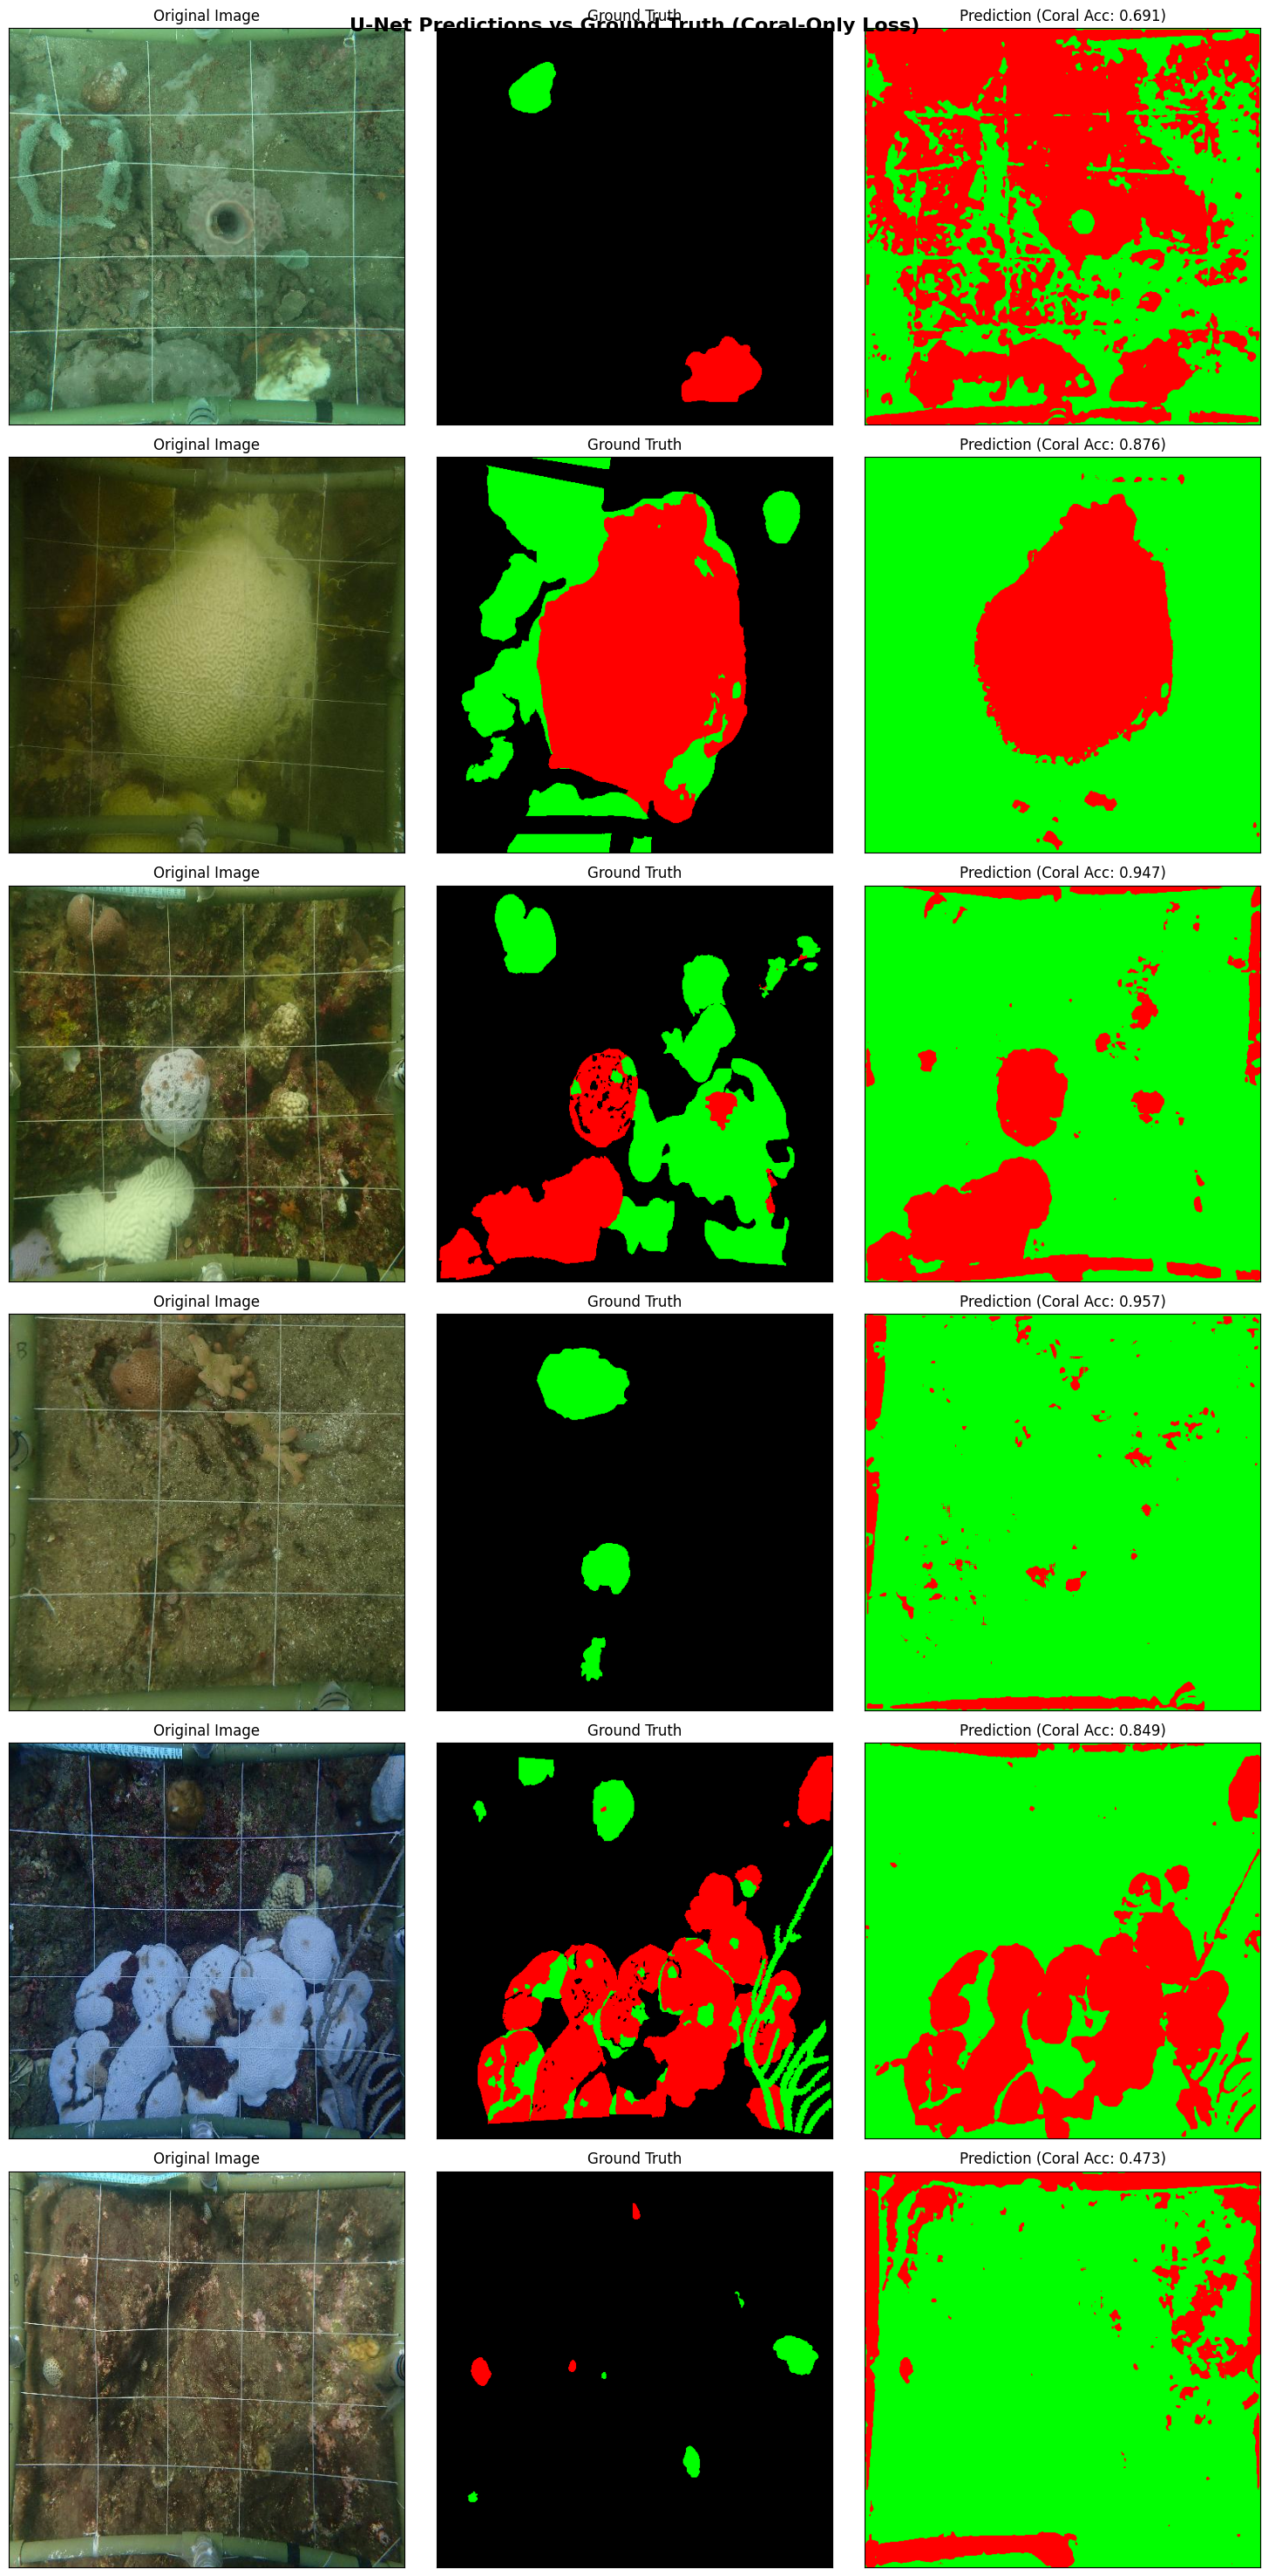

Training history saved to /kaggle/working/coral_training_history.png


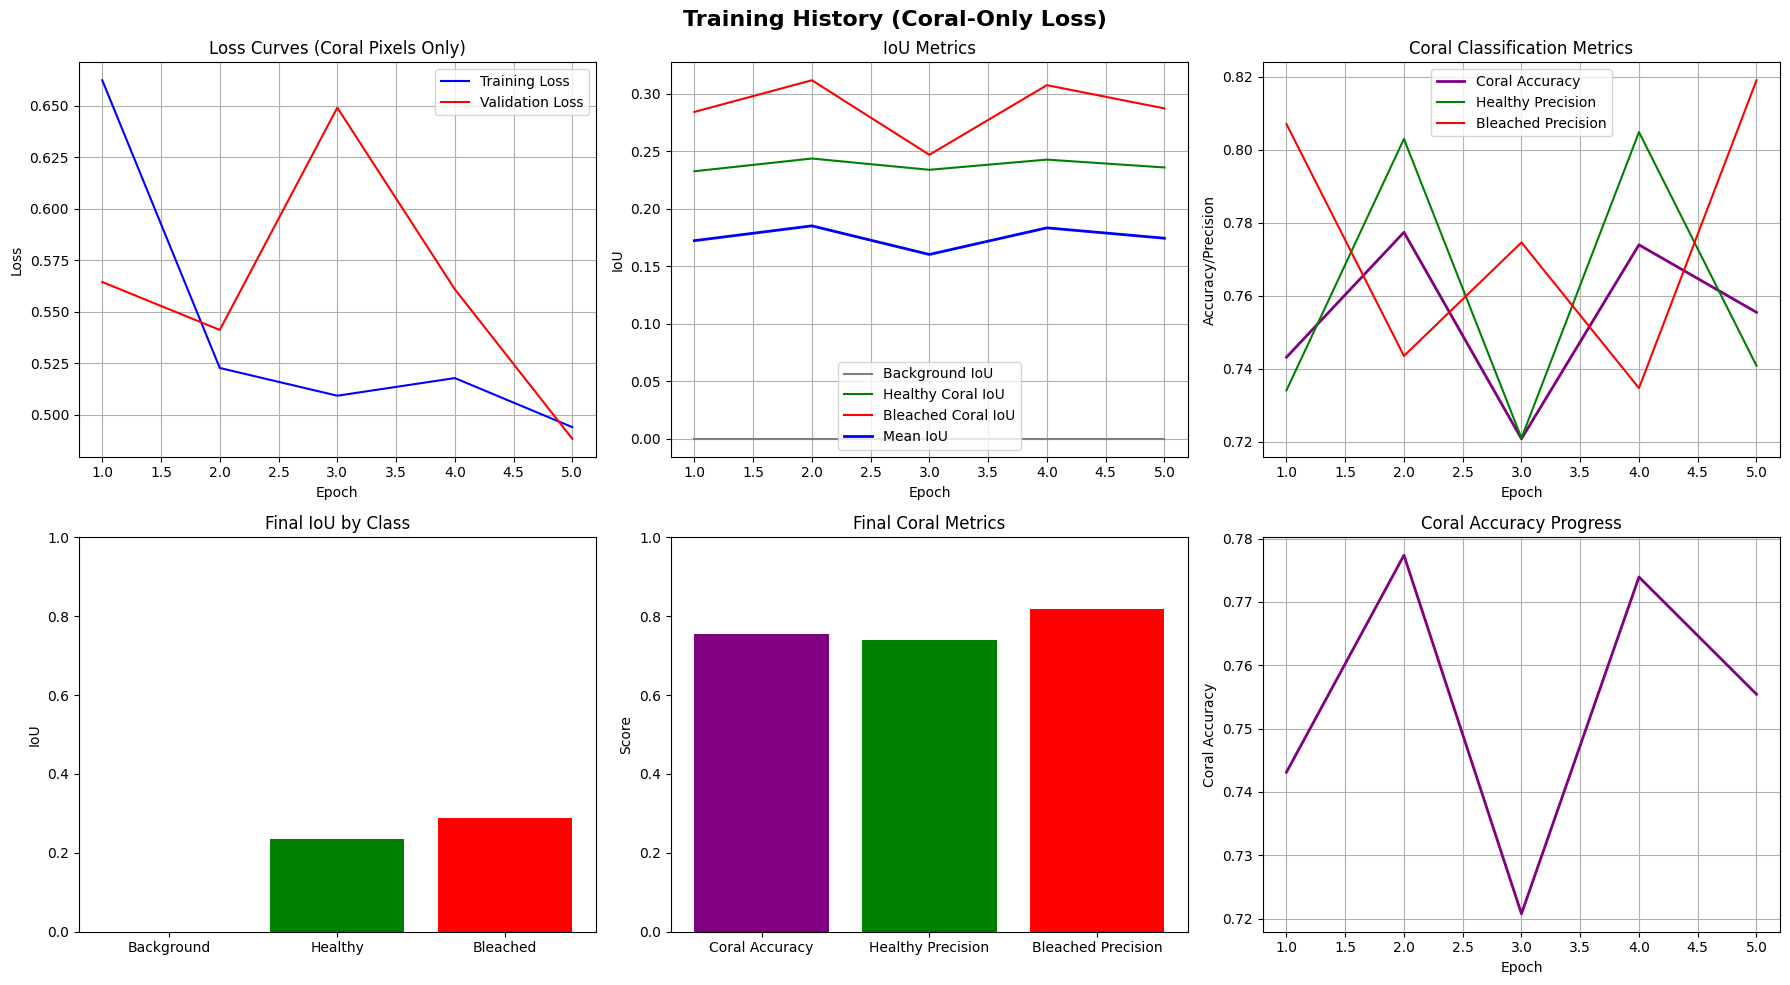

✅ Training complete with coral-only loss!


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import json
from tqdm import tqdm
from sklearn.metrics import jaccard_score
import cv2

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class CoralDataset(Dataset):
    """Dataset class for coral bleaching data"""
    
    def __init__(self, data_dir, split='train', transform=None):
        """
        Args:
            data_dir: Path to preprocessed dataset
            split: 'train' or 'val'
            transform: Optional transforms
        """
        self.data_dir = Path(data_dir) / split
        self.transform = transform
        
        # Get all image files
        self.image_files = [f for f in os.listdir(self.data_dir / 'images') 
                           if f.endswith('.npy')]
        
        print(f"Found {len(self.image_files)} {split} samples")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Get filename without extension
        img_file = self.image_files[idx]
        base_name = os.path.splitext(img_file)[0]
        
        # Load image and masks
        image = np.load(self.data_dir / 'images' / img_file)
        bleach_mask = np.load(self.data_dir / 'masks_bleached' / f'{base_name}_bleached.npy')
        healthy_mask = np.load(self.data_dir / 'masks_non_bleached' / f'{base_name}_non_bleached.npy')
        
        # Create 3-class segmentation mask
        # 0 = background, 1 = healthy coral, 2 = bleached coral
        segmentation_mask = np.zeros_like(bleach_mask, dtype=np.int64)
        segmentation_mask[healthy_mask == 1] = 1    # Healthy coral = class 1
        segmentation_mask[bleach_mask == 1] = 2     # Bleached coral = class 2
        
        # Convert to torch tensors
        if len(image.shape) == 3:  # RGB image
            image = torch.from_numpy(image.transpose(2, 0, 1)).float()  # HWC -> CHW
        else:  # Grayscale
            image = torch.from_numpy(image).unsqueeze(0).float()  # Add channel dim
        
        mask = torch.from_numpy(segmentation_mask).long()
        
        # Apply transforms if any
        if self.transform:
            image, mask = self.transform(image, mask)
        
        return image, mask

class DoubleConv(nn.Module):
    """Double convolution block used in U-Net"""
    
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """U-Net architecture for coral bleaching segmentation"""
    
    def __init__(self, n_channels=3, n_classes=3, base_channels=64):
        """
        Args:
            n_channels: Number of input channels (3 for RGB)
            n_classes: Number of output classes (3: background, healthy, bleached)
            base_channels: Base number of channels (64 is standard)
        """
        super(UNet, self).__init__()
        
        # Encoder (contracting path)
        self.inc = DoubleConv(n_channels, base_channels)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base_channels, base_channels*2))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base_channels*2, base_channels*4))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base_channels*4, base_channels*8))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(base_channels*8, base_channels*16))
        
        # Decoder (expanding path)
        self.up1 = nn.ConvTranspose2d(base_channels*16, base_channels*8, 2, stride=2)
        self.conv1 = DoubleConv(base_channels*16, base_channels*8)
        
        self.up2 = nn.ConvTranspose2d(base_channels*8, base_channels*4, 2, stride=2)
        self.conv2 = DoubleConv(base_channels*8, base_channels*4)
        
        self.up3 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 2, stride=2)
        self.conv3 = DoubleConv(base_channels*4, base_channels*2)
        
        self.up4 = nn.ConvTranspose2d(base_channels*2, base_channels, 2, stride=2)
        self.conv4 = DoubleConv(base_channels*2, base_channels)
        
        # Final classifier
        self.outc = nn.Conv2d(base_channels, n_classes, 1)
    
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)      # 64 channels
        x2 = self.down1(x1)   # 128 channels
        x3 = self.down2(x2)   # 256 channels
        x4 = self.down3(x3)   # 512 channels
        x5 = self.down4(x4)   # 1024 channels
        
        # Decoder with skip connections
        x = self.up1(x5)                           # Upsample
        x = torch.cat([x4, x], dim=1)              # Skip connection
        x = self.conv1(x)                          # Double conv
        
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)
        
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)
        
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)
        
        # Final prediction
        logits = self.outc(x)
        return logits

class CoralOnlyCrossEntropyLoss(nn.Module):
    """Cross-entropy loss that only considers coral pixels (ignores background)"""
    
    def __init__(self, weights=None, ignore_index=0):
        """
        Args:
            weights: Class weights for healthy (1) and bleached (2) coral
            ignore_index: Index to ignore (0 for background)
        """
        super(CoralOnlyCrossEntropyLoss, self).__init__()
        self.ignore_index = ignore_index
        self.weights = weights
        if weights is not None:
            # Only include weights for coral classes (1 and 2)
            self.weights = torch.tensor(weights, dtype=torch.float32)
    
    def forward(self, inputs, targets):
        """
        Args:
            inputs: Model predictions (B, C, H, W)
            targets: Ground truth masks (B, H, W) with values 0, 1, 2
        """
        # Create mask for coral pixels only (exclude background = 0)
        coral_mask = targets != self.ignore_index
        
        if not coral_mask.any():
            # If no coral pixels in batch, return zero loss
            return torch.tensor(0.0, requires_grad=True, device=inputs.device)
        
        # Flatten tensors
        inputs_flat = inputs.permute(0, 2, 3, 1).contiguous().view(-1, inputs.size(1))  # (B*H*W, C)
        targets_flat = targets.view(-1)  # (B*H*W,)
        coral_mask_flat = coral_mask.view(-1)  # (B*H*W,)
        
        # Select only coral pixels
        inputs_coral = inputs_flat[coral_mask_flat]  # (N_coral, C)
        targets_coral = targets_flat[coral_mask_flat]  # (N_coral,)
        
        # Apply cross-entropy loss only on coral pixels
        if self.weights is not None:
            self.weights = self.weights.to(inputs.device)
            # Create weight tensor for selected coral pixels
            pixel_weights = torch.zeros_like(targets_coral, dtype=torch.float32)
            pixel_weights[targets_coral == 1] = self.weights[0]  # Healthy coral weight
            pixel_weights[targets_coral == 2] = self.weights[1]  # Bleached coral weight
            
            loss = F.cross_entropy(inputs_coral, targets_coral, reduction='none')
            loss = (loss * pixel_weights).mean()
        else:
            loss = F.cross_entropy(inputs_coral, targets_coral)
        
        return loss

def calculate_coral_class_weights(dataloader):
    """Calculate class weights based on frequency of coral pixels only"""
    class_counts = torch.zeros(2)  # Only 2 classes: healthy, bleached (ignoring background)
    
    print("Calculating coral class weights...")
    for images, masks in tqdm(dataloader):
        # Count only coral pixels (1 = healthy, 2 = bleached)
        class_counts[0] += torch.sum(masks == 1)  # Healthy coral
        class_counts[1] += torch.sum(masks == 2)  # Bleached coral
    
    # Calculate weights (inverse frequency)
    total_coral_pixels = class_counts.sum()
    class_weights = total_coral_pixels / (2 * class_counts)
    
    print(f"Coral class distribution:")
    print(f"  Healthy coral: {class_counts[0]:,.0f} pixels ({class_counts[0]/total_coral_pixels:.1%})")
    print(f"  Bleached coral: {class_counts[1]:,.0f} pixels ({class_counts[1]/total_coral_pixels:.1%})")
    print(f"Coral class weights: {class_weights.tolist()}")
    
    return class_weights

def calculate_iou(pred_mask, true_mask, num_classes=3):
    """Calculate IoU (Intersection over Union) for each class"""
    ious = []
    
    for class_id in range(num_classes):
        pred_class = (pred_mask == class_id)
        true_class = (true_mask == class_id)
        
        intersection = torch.sum(pred_class & true_class).float()
        union = torch.sum(pred_class | true_class).float()
        
        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0  # Perfect if both are empty
        else:
            iou = intersection / union
        
        ious.append(iou.item())
    
    return ious

def calculate_coral_metrics(pred_mask, true_mask):
    """Calculate metrics focusing on coral classification accuracy"""
    # Create masks for coral pixels only
    coral_mask = true_mask > 0  # All coral pixels (healthy + bleached)
    
    if not coral_mask.any():
        return {'coral_accuracy': 0.0, 'healthy_precision': 0.0, 'bleached_precision': 0.0}
    
    # Extract predictions and targets for coral pixels only
    pred_coral = pred_mask[coral_mask]
    true_coral = true_mask[coral_mask]
    
    # Calculate accuracy on coral pixels only
    coral_accuracy = (pred_coral == true_coral).float().mean().item()
    
    # Calculate precision for each coral class
    healthy_mask = true_coral == 1
    bleached_mask = true_coral == 2
    
    healthy_precision = 0.0
    if healthy_mask.any():
        healthy_precision = (pred_coral[healthy_mask] == 1).float().mean().item()
    
    bleached_precision = 0.0
    if bleached_mask.any():
        bleached_precision = (pred_coral[bleached_mask] == 2).float().mean().item()
    
    return {
        'coral_accuracy': coral_accuracy,
        'healthy_precision': healthy_precision,
        'bleached_precision': bleached_precision
    }

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, 
               coral_class_weights=None, save_dir='/kaggle/working'):
    """Train the U-Net model with coral-only loss"""
    
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Loss and optimizer - using coral-only loss
    criterion = CoralOnlyCrossEntropyLoss(weights=coral_class_weights, ignore_index=0)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_iou_background': [],
        'val_iou_healthy': [],
        'val_iou_bleached': [],
        'val_mean_iou': [],
        'val_coral_accuracy': [],
        'val_healthy_precision': [],
        'val_bleached_precision': []
    }
    
    best_val_iou = 0.0
    
    print(f"\n🚀 Starting training for {num_epochs} epochs with coral-only loss...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, masks in train_bar:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_ious = [[], [], []]  # For each class
        all_coral_metrics = {'coral_accuracy': [], 'healthy_precision': [], 'bleached_precision': []}
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, masks in val_bar:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Calculate IoU
                pred_masks = torch.argmax(outputs, dim=1)
                batch_ious = calculate_iou(pred_masks, masks)
                
                for i, iou in enumerate(batch_ious):
                    all_ious[i].append(iou)
                
                # Calculate coral-specific metrics
                coral_metrics = calculate_coral_metrics(pred_masks, masks)
                for key, value in coral_metrics.items():
                    all_coral_metrics[key].append(value)
                
                val_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        val_loss /= len(val_loader)
        
        # Average IoUs
        avg_ious = [np.mean(class_ious) for class_ious in all_ious]
        mean_iou = np.mean(avg_ious)
        
        # Average coral metrics
        avg_coral_metrics = {key: np.mean(values) for key, values in all_coral_metrics.items()}
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_iou_background'].append(avg_ious[0])
        history['val_iou_healthy'].append(avg_ious[1])
        history['val_iou_bleached'].append(avg_ious[2])
        history['val_mean_iou'].append(mean_iou)
        history['val_coral_accuracy'].append(avg_coral_metrics['coral_accuracy'])
        history['val_healthy_precision'].append(avg_coral_metrics['healthy_precision'])
        history['val_bleached_precision'].append(avg_coral_metrics['bleached_precision'])
        
        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f} (coral pixels only)')
        print(f'  Val Loss: {val_loss:.4f} (coral pixels only)')
        print(f'  Val IoU - Background: {avg_ious[0]:.4f}')
        print(f'  Val IoU - Healthy: {avg_ious[1]:.4f}')
        print(f'  Val IoU - Bleached: {avg_ious[2]:.4f}')
        print(f'  Mean IoU: {mean_iou:.4f}')
        print(f'  Coral Accuracy: {avg_coral_metrics["coral_accuracy"]:.4f}')
        print(f'  Healthy Precision: {avg_coral_metrics["healthy_precision"]:.4f}')
        print(f'  Bleached Precision: {avg_coral_metrics["bleached_precision"]:.4f}')
        
        # Save best model based on coral accuracy
        coral_accuracy = avg_coral_metrics['coral_accuracy']
        if coral_accuracy > best_val_iou:
            best_val_iou = coral_accuracy
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'coral_accuracy': coral_accuracy,
                'mean_iou': mean_iou,
                'history': history
            }, save_dir / 'best_unet_coral_model.pth')
            print(f'  💾 New best model saved! (Coral Accuracy: {coral_accuracy:.4f})')
    
    return history

def visualize_predictions(model, val_loader, num_samples=6, save_path=None):
    """Visualize model predictions vs ground truth"""
    model.eval()
    
    # Get some validation samples
    data_iter = iter(val_loader)
    images, true_masks = next(data_iter)
    
    # Make predictions
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        pred_masks = torch.argmax(outputs, dim=1).cpu().numpy()
    
    images = images.cpu().numpy()
    true_masks = true_masks.cpu().numpy()
    
    # Create visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('U-Net Predictions vs Ground Truth (Coral-Only Loss)', fontsize=16, fontweight='bold')
    
    # Color maps for classes
    class_colors = np.array([
        [0, 0, 0],        # Background - black
        [0, 255, 0],      # Healthy coral - green  
        [255, 0, 0]       # Bleached coral - red
    ])
    
    for i in range(min(num_samples, len(images))):
        # Original image
        img = images[i].transpose(1, 2, 0)  # CHW -> HWC
        if img.shape[2] == 1:  # Grayscale
            img = img.squeeze()
            axes[i, 0].imshow(img, cmap='gray')
        else:  # RGB
            axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        
        # Ground truth
        true_colored = class_colors[true_masks[i]]
        axes[i, 1].imshow(true_colored)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])
        
        # Prediction
        pred_colored = class_colors[pred_masks[i]]
        axes[i, 2].imshow(pred_colored)
        
        # Calculate coral accuracy for this sample
        coral_mask = true_masks[i] > 0
        if coral_mask.any():
            coral_acc = (pred_masks[i][coral_mask] == true_masks[i][coral_mask]).mean()
            axes[i, 2].set_title(f'Prediction (Coral Acc: {coral_acc:.3f})')
        else:
            axes[i, 2].set_title('Prediction (No coral pixels)')
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Predictions saved to {save_path}")
    
    plt.show()

def plot_training_history(history, save_path=None):
    """Plot training history with coral-specific metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training History (Coral-Only Loss)', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss curves
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    axes[0, 0].set_title('Loss Curves (Coral Pixels Only)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # IoU curves
    axes[0, 1].plot(epochs, history['val_iou_background'], 'gray', label='Background IoU')
    axes[0, 1].plot(epochs, history['val_iou_healthy'], 'green', label='Healthy Coral IoU')
    axes[0, 1].plot(epochs, history['val_iou_bleached'], 'red', label='Bleached Coral IoU')
    axes[0, 1].plot(epochs, history['val_mean_iou'], 'blue', label='Mean IoU', linewidth=2)
    axes[0, 1].set_title('IoU Metrics')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Coral-specific metrics
    axes[0, 2].plot(epochs, history['val_coral_accuracy'], 'purple', label='Coral Accuracy', linewidth=2)
    axes[0, 2].plot(epochs, history['val_healthy_precision'], 'green', label='Healthy Precision')
    axes[0, 2].plot(epochs, history['val_bleached_precision'], 'red', label='Bleached Precision')
    axes[0, 2].set_title('Coral Classification Metrics')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Accuracy/Precision')
    axes[0, 2].legend()
    axes[0, 2].grid(True)
    
    # Final IoU by class
    final_ious = [
        history['val_iou_background'][-1],
        history['val_iou_healthy'][-1], 
        history['val_iou_bleached'][-1]
    ]
    axes[1, 0].bar(['Background', 'Healthy', 'Bleached'], final_ious, 
                   color=['gray', 'green', 'red'])
    axes[1, 0].set_title('Final IoU by Class')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].set_ylim(0, 1)
    
    # Final coral metrics
    final_coral_metrics = [
        history['val_coral_accuracy'][-1],
        history['val_healthy_precision'][-1],
        history['val_bleached_precision'][-1]
    ]
    axes[1, 1].bar(['Coral Accuracy', 'Healthy Precision', 'Bleached Precision'], 
                   final_coral_metrics, color=['purple', 'green', 'red'])
    axes[1, 1].set_title('Final Coral Metrics')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_ylim(0, 1)
    
    # Coral accuracy trend
    axes[1, 2].plot(epochs, history['val_coral_accuracy'], 'purple', linewidth=2)
    axes[1, 2].set_title('Coral Accuracy Progress')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Coral Accuracy')
    axes[1, 2].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Training history saved to {save_path}")
    
    plt.show()

# Complete training pipeline
def run_coral_unet_training(data_dir, batch_size=8, num_epochs=50, learning_rate=0.001):
    """Complete training pipeline for coral bleaching U-Net with coral-only loss"""
    
    print("🔬 CORAL BLEACHING U-NET TRAINING PIPELINE (CORAL-ONLY LOSS)")
    print("="*60)
    
    # 1. Create datasets
    train_dataset = CoralDataset(data_dir, split='train')
    val_dataset = CoralDataset(data_dir, split='val')
    
    # 2. Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    print(f"📊 Dataset sizes:")
    print(f"  Training: {len(train_dataset)} images")
    print(f"  Validation: {len(val_dataset)} images")
    print(f"  Batch size: {batch_size}")
    
    # 3. Calculate coral class weights (only for coral classes)
    coral_class_weights = calculate_coral_class_weights(train_loader)
    
    # 4. Create model
    model = UNet(n_channels=3, n_classes=3, base_channels=64)
    model = model.to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"🏗️ Model created with {total_params:,} parameters")
    print("🎯 Using coral-only loss function (ignoring background pixels)")
    
    # 5. Train model
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        coral_class_weights=coral_class_weights
    )
    
    # 6. Visualize results
    print("\n📊 Visualizing results...")
    visualize_predictions(model, val_loader, num_samples=6, 
                         save_path='/kaggle/working/unet_coral_predictions.png')
    
    plot_training_history(history, save_path='/kaggle/working/coral_training_history.png')
    
    print("✅ Training complete with coral-only loss!")
    return model, history

# Example usage
if __name__ == "__main__":
    # Set paths
    data_dir = '/kaggle/input/coral-prossessed/coral_dataset_final'  # Your preprocessed data
    
    # Run training
    model, history = run_coral_unet_training(
        data_dir=data_dir,
        batch_size=8,        # Adjust based on GPU memory
        num_epochs=5,       # Start with 30 epochs
        learning_rate=0.001
    )